In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
chicago = gpd.read_file("chicago_tnp.geojson")

In [3]:
chicago['pct_white'] = 1-chicago['pct_nonwhite']
# centroids
chicago['x_coord'] = chicago.geometry.centroid.x
chicago['y_coord'] = chicago.geometry.centroid.y
# log transformation
chicago['Trips_log'] = np.log(chicago['TripCount'])
chicago['PD_log'] = np.log(chicago['population_den'])

Text(0.5, 1.0, 'Map of Log(Trip Demand) ')

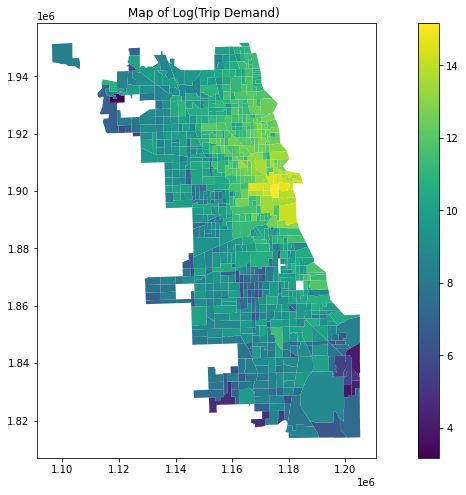

In [4]:
ax = chicago.plot(column='Trips_log',legend=True,figsize=(15,8),cmap='viridis')
plt.title("Map of Log(Trip Demand) ")

In [5]:
X_vars = ['pct_18to34','pct_white','pct_bachelorORhigher',
          'pct_no_vehicle','PD_log','job_entropy','network_den',
          'TripMiles_mean','pct_share']

X = chicago[X_vars]
X_coords = chicago[X_vars + ['x_coord','y_coord']]
y = chicago['Trips_log']

In [6]:
corr = X_coords.corr()
corr.style.background_gradient(cmap='coolwarm')

,pct_18to34,pct_white,pct_bachelorORhigher,pct_no_vehicle,PD_log,job_entropy,network_den,TripMiles_mean,pct_share,x_coord,y_coord
pct_18to34,1.000000,0.390877,0.622026,0.195909,0.490336,0.241896,0.220743,-0.516096,-0.479450,0.170357,0.324193
pct_white,0.390877,1.000000,0.623526,-0.427696,0.370135,0.543668,0.143289,-0.239681,-0.823631,-0.339173,0.592385
pct_bachelorORhigher,0.622026,0.623526,1.000000,-0.047402,0.442706,0.418881,0.289380,-0.482170,-0.819477,0.157823,0.472446
pct_no_vehicle,0.195909,-0.427696,-0.047402,1.000000,0.187158,-0.245047,0.062668,-0.209084,0.231612,0.431191,-0.084703
PD_log,0.490336,0.370135,0.442706,0.187158,1.000000,0.144143,0.214653,-0.445175,-0.451349,0.038934,0.482243
job_entropy,0.241896,0.543668,0.418881,-0.245047,0.144143,1.000000,0.140010,-0.269284,-0.523861,-0.217552,0.394626
network_den,0.220743,0.143289,0.289380,0.062668,0.214653,0.140010,1.000000,-0.378175,-0.245315,0.045917,0.167197
TripMiles_mean,-0.516096,-0.239681,-0.482170,-0.209084,-0.445175,-0.269284,-0.378175,1.000000,0.417695,0.044955,-0.544331
pct_share,-0.479450,-0.823631,-0.819477,0.231612,-0.451349,-0.523861,-0.245315,0.417695,1.000000,0.169171,-0.613252
x_coord,0.170357,-0.339173,0.157823,0.431191,0.038934,-0.217552,0.045917,0.044955,0.169171,1.000000,-0.511766


### Machine Learning

In [7]:
import xgboost
import shap

from sklearn.metrics import mean_squared_error, r2_score

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_coords, y, 
                                                    test_size = 0.2,
                                                    random_state = 222)

### Hyperparameter Tuning

In [9]:
%%time
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

# Choose hyperparameter domain to search over
space = {
        'max_depth':hp.choice('max_depth', np.arange(1, 30, 1, dtype=int)),
        'colsample_bytree':hp.quniform('colsample_bytree', 0.3, 1.01, 0.05),
        'min_child_weight':hp.choice('min_child_weight', np.arange(1, 30, 1, dtype=int)),
        'subsample':        hp.quniform('subsample', 0.3, 1.01, 0.05),
        'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 1.01, 0.05)),
        'gamma': hp.quniform('gamma', 0.1, 5, 0.05),
    
        'objective':'reg:squarederror',
        'eval_metric': 'rmse',
    }

def score(params, n_folds=5):
    
    #Cross-validation
    d_train = xgboost.DMatrix(X_coords,y)
    
    cv_results = xgboost.cv(params, d_train, nfold = n_folds, num_boost_round=500,
                        early_stopping_rounds = 10, metrics = 'rmse', seed = 0)
    
    loss = min(cv_results['test-rmse-mean'])
    
    return loss


def optimize(trials, space):
    
    best = fmin(score, space, algo=tpe.suggest, max_evals=2000,
                rstate=np.random.RandomState(333))#Add seed to fmin function
    return best


CPU times: user 182 ms, sys: 83.9 ms, total: 266 ms
Wall time: 473 ms


In [10]:
trials = Trials()
best_params = optimize(trials, space)

# Return the best parameters
best_params = space_eval(space, best_params)

best_params

100%|██████████| 2000/2000 [14:28<00:00,  2.30trial/s, best loss: 0.8733162]         


{'colsample_bytree': 0.75,
 'eval_metric': 'rmse',
 'gamma': 0.15000000000000002,
 'learning_rate': 0.05,
 'max_depth': 18,
 'min_child_weight': 3,
 'objective': 'reg:squarederror',
 'subsample': 0.75}

### Fit xgboost model

In [11]:
data_test = xgboost.DMatrix(X_test,y_test)

data = xgboost.DMatrix(X_train,y_train)
final_model = xgboost.train(best_params, data, num_boost_round=500, verbose_eval=False,
                            evals=[(data_test, "Test")],early_stopping_rounds=10)


data_all = xgboost.DMatrix(X_coords)
y_pred = final_model.predict(data_all)
print(np.sqrt(mean_squared_error(y, y_pred)))
print(r2_score(y, y_pred))

0.44647018017266515
0.9414024026575328


## SHAP analysis of xgboost results

In [12]:
explainer_shap = shap.TreeExplainer(final_model)
shap_values = explainer_shap(X_coords)

In [13]:
shap_interaction_values = shap.TreeExplainer(
    final_model).shap_interaction_values(X_coords)

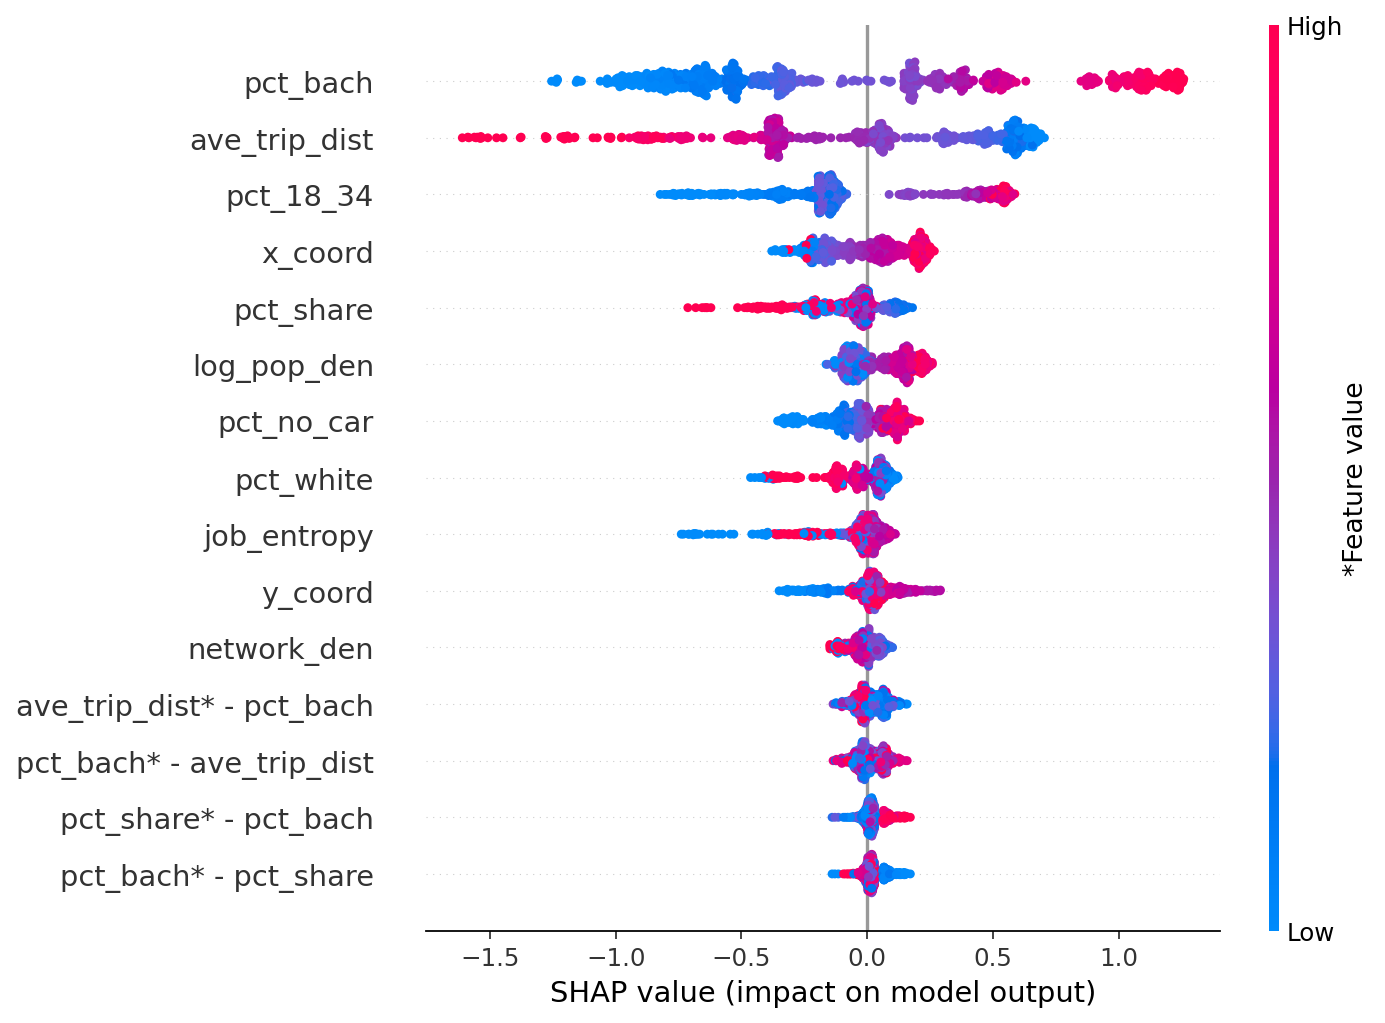

In [14]:
X_names = ['pct_18_34','pct_white','pct_bach',
          'pct_no_car','log_pop_den','job_entropy','network_den',
          'ave_trip_dist','pct_share','x_coord','y_coord']

fig, ax = plt.subplots(figsize=(8, 6),dpi=160)

shap.summary_plot(shap_interaction_values, X_coords, max_display=15, 
                  feature_names = X_names,
                  plot_type="compact_dot")

## Compute Confidence intervals for SHAPs

```
Function to compute 95% confidence interval around SHAP estimates
       Residual reampling-based boostrapping
    Step:  Repeat N times:
            1) Randomly resample residuals with replacement.
            2) Model Y_pred + residuals ~ X
            3) Compute SHAP values and save them
    Get the 2.5 percentile and 97.5 percentile from the sampling distribution.
```

In [15]:
from tqdm import tqdm

shap_bootstrap_list = []

def boostrap_shap(y_pred):
    n = y.shape[0]
    err = y - y_pred
    
    for i in tqdm(range(5000)):
        
        random_sample_index = np.random.choice(np.arange(n), size=n, replace=True)
        
        y_sample = y_pred + err[random_sample_index]
        
        sample_data = xgboost.DMatrix(X_coords,y_sample)
        
        sample_model = xgboost.train(best_params, sample_data, num_boost_round=500,verbose_eval=False,
                            evals=[(data_test, "Test")],early_stopping_rounds=10)
    
        explainer_shap = shap.Explainer(sample_model)
        shap_values = explainer_shap(X_coords)

        shap_bootstrap_list.append(shap_values.values)
        
    return np.array(shap_bootstrap_list)

In [16]:
%%time
np.random.seed(333)

shap_bootstrap_list = boostrap_shap(y_pred)

100%|██████████| 5000/5000 [1:21:57<00:00,  1.02it/s]

CPU times: user 5h 38min 15s, sys: 4min 25s, total: 5h 42min 41s
Wall time: 1h 21min 58s


### Compute the confidence intervals for the global shap values

In [17]:
l_shap_global = np.abs(shap_bootstrap_list).mean(axis=1).mean(axis=0) - \
                np.percentile(np.abs(shap_bootstrap_list).mean(axis=1),axis=0, q=2.5)
                
u_shap_global = np.percentile(np.abs(shap_bootstrap_list).mean(axis=1),axis=0, q=97.5) - \
                np.abs(shap_bootstrap_list).mean(axis=1).mean(axis=0)

df_mean_shap = pd.DataFrame(np.vstack([np.array(X_coords.columns), 
                        np.abs(shap_bootstrap_list).mean(axis=1).mean(axis=0),
                        l_shap_global, u_shap_global,
                        np.percentile(np.abs(shap_bootstrap_list).mean(axis=1),axis=0, q=2.5),
                        np.percentile(np.abs(shap_bootstrap_list).mean(axis=1),axis=0, q=97.5) 
                                      ]).T,
                            columns=['Feature','SHAP', 'SHAP_err_l',
                                     'SHAP_err_u','SHAP_l','SHAP_u'])

In [18]:
df_mean_shap = df_mean_shap.sort_values(by="SHAP",ascending=True)

df_mean_shap["SHAP"] = df_mean_shap["SHAP"].astype("float")
df_mean_shap["SHAP_err_u"] = df_mean_shap["SHAP_err_u"].astype("float")
df_mean_shap["SHAP_err_l"] = df_mean_shap["SHAP_err_l"].astype("float")

## Global feature importance

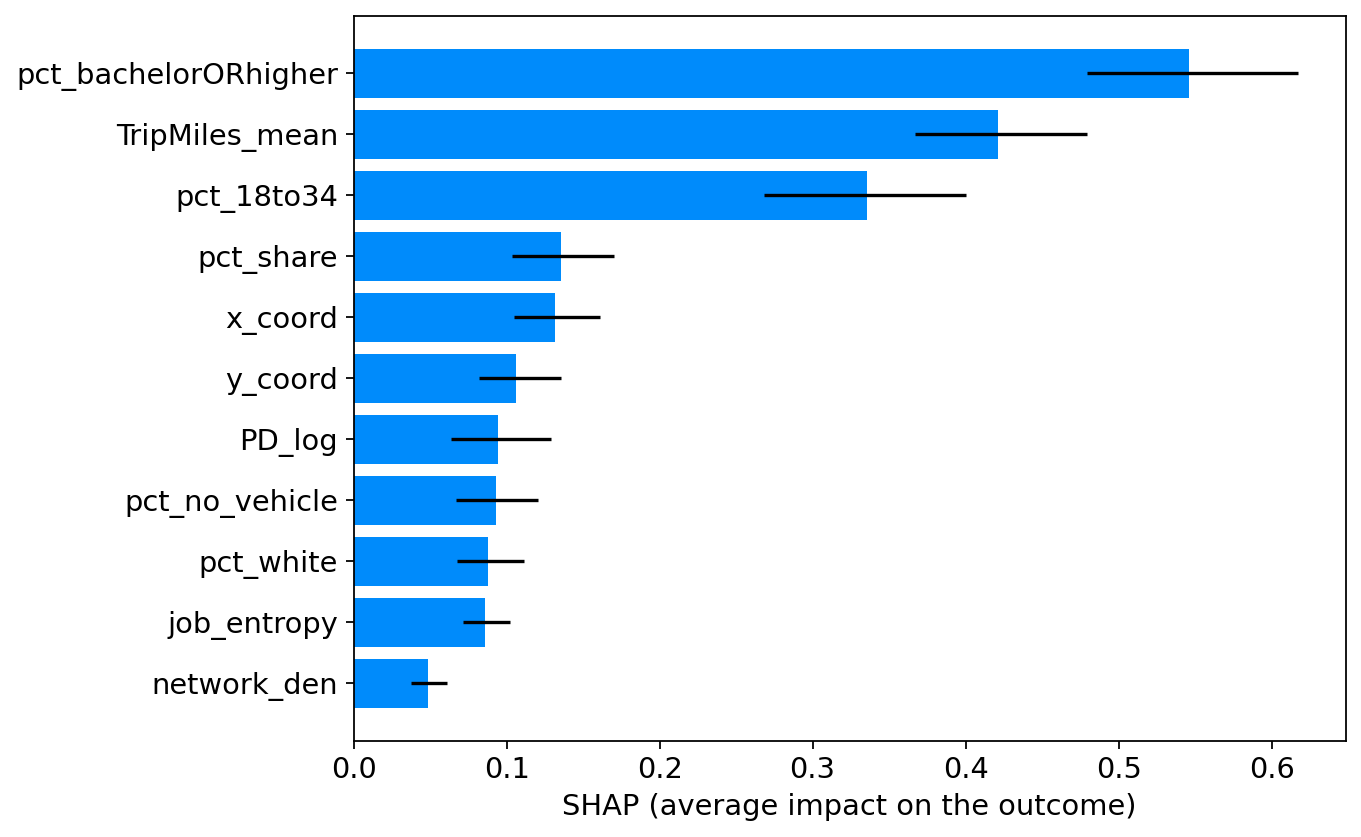

In [19]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8,6),dpi=160)

ax.barh(df_mean_shap.Feature, df_mean_shap.SHAP,
        xerr=df_mean_shap[['SHAP_err_l','SHAP_err_u']].values.T,color=shap.plots.colors.blue_rgb)

ax.set_xlabel('SHAP (average impact on the outcome)',fontsize=13)
ax.tick_params(labelsize=13)

### Visualize the confidence intervals for the local shap values

In [20]:
#Compute the 95% confidence interval
l_95 = np.percentile(shap_bootstrap_list,axis=0,q=2.5)
u_95 = np.percentile(shap_bootstrap_list,axis=0,q=97.5)

In [21]:
import seaborn as sns

def plot(ax,term=0):
    
    order = np.argsort(X_coords.values[:,term])

    ax.fill_between(X_coords.values[:,term][order], l_95[:,term][order], 
                     u_95[:,term][order],color='lightblue',alpha=0.6)
    
    ax.scatter(X_coords.values[:,term][order], shap_bootstrap_list.mean(axis=0)[:,term][order],
                s=10,color='black')
    
    ax.axhline(0,color='r', linestyle='--',)
    ax.set_xlabel(X_names[term],fontsize=13)
    #ax.set_ylim(-2.5,2.5)
    ax.set_ylabel("SHAP value",fontsize=13)
    plt.tight_layout()


## Partial Dependence Plots

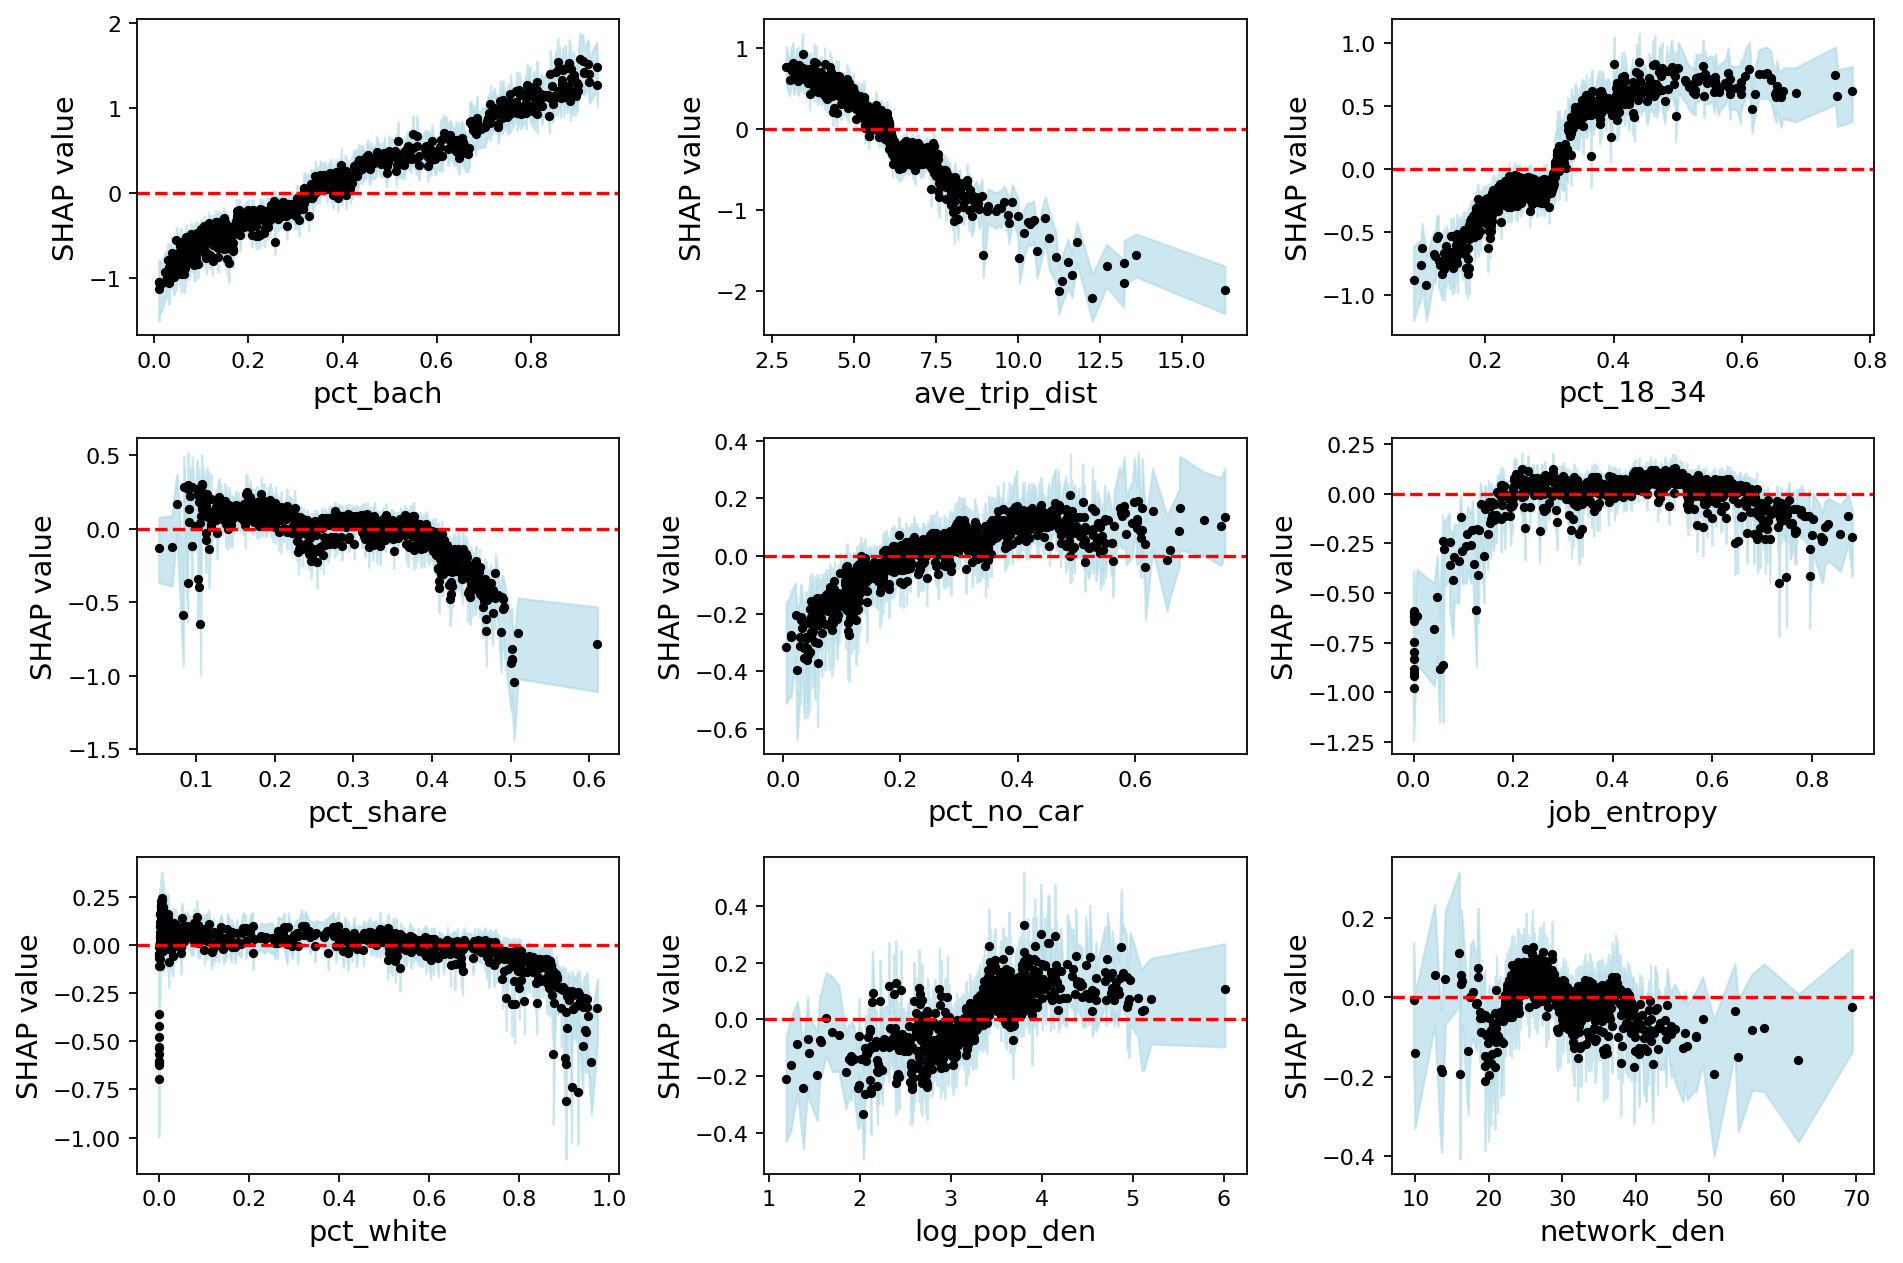

In [22]:
fig, ax = plt.subplots(3,3,figsize=(12,8),dpi=160)
ax = ax.ravel()
index = 0
for j in [2, 7, 0, 8, 3, 5, 1, 4, 6 ]:
    plot(ax=ax[index],term=j)
    index += 1
    
#fig.delaxes(ax[-1])
#fig.delaxes(ax[-2])

## Spatial patterns of SHAP values

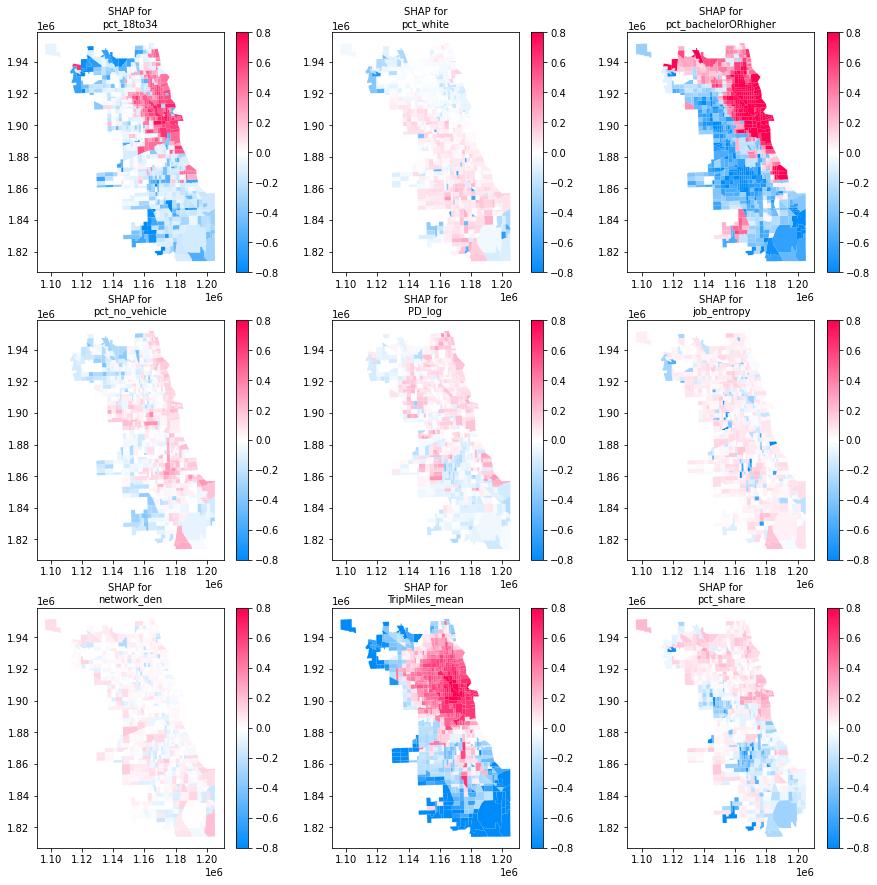

In [23]:
fig, ax = plt.subplots(3,3,figsize=(15,15))

for j in range(len(X_vars)):
    ax = ax.ravel()
    chicago.plot(ax=ax[j],column = shap_values.values[:,j],legend=True,
             vmin=-0.8,vmax=0.8,cmap=shap.plots.colors.red_white_blue)
    
    ax[j].set_title("SHAP for\n" + X_vars[j],fontsize=10)
    
#fig.delaxes(ax[-1])

### Location Effect Map

(1090883.0228337517,
 1210722.3614912494,
 1806999.3005625033,
 1958619.5146374977)

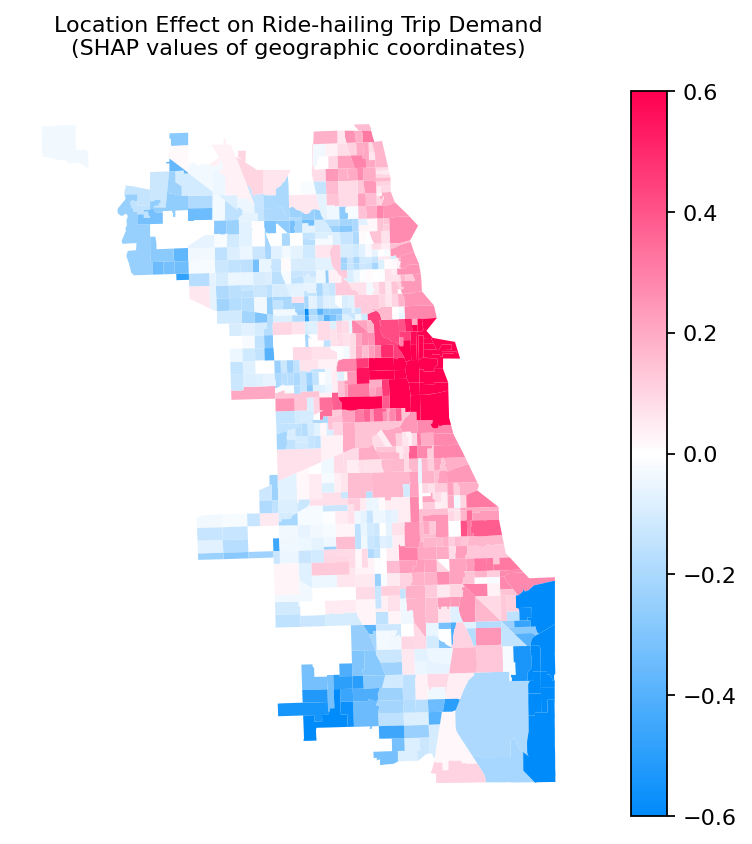

In [24]:
fig, ax = plt.subplots(figsize=(8,6),dpi=160)

chicago.plot(ax=ax,column = shap_values.values[:,-1] + shap_values.values[:,-2],
             legend=True,vmin=-0.6,vmax=0.6,figsize=(10, 10),
                cmap=shap.plots.colors.red_white_blue)

plt.title("Location Effect on Ride-hailing Trip Demand\n(SHAP values of geographic coordinates)\n",fontsize=10)

plt.axis('off')

## Feature maps

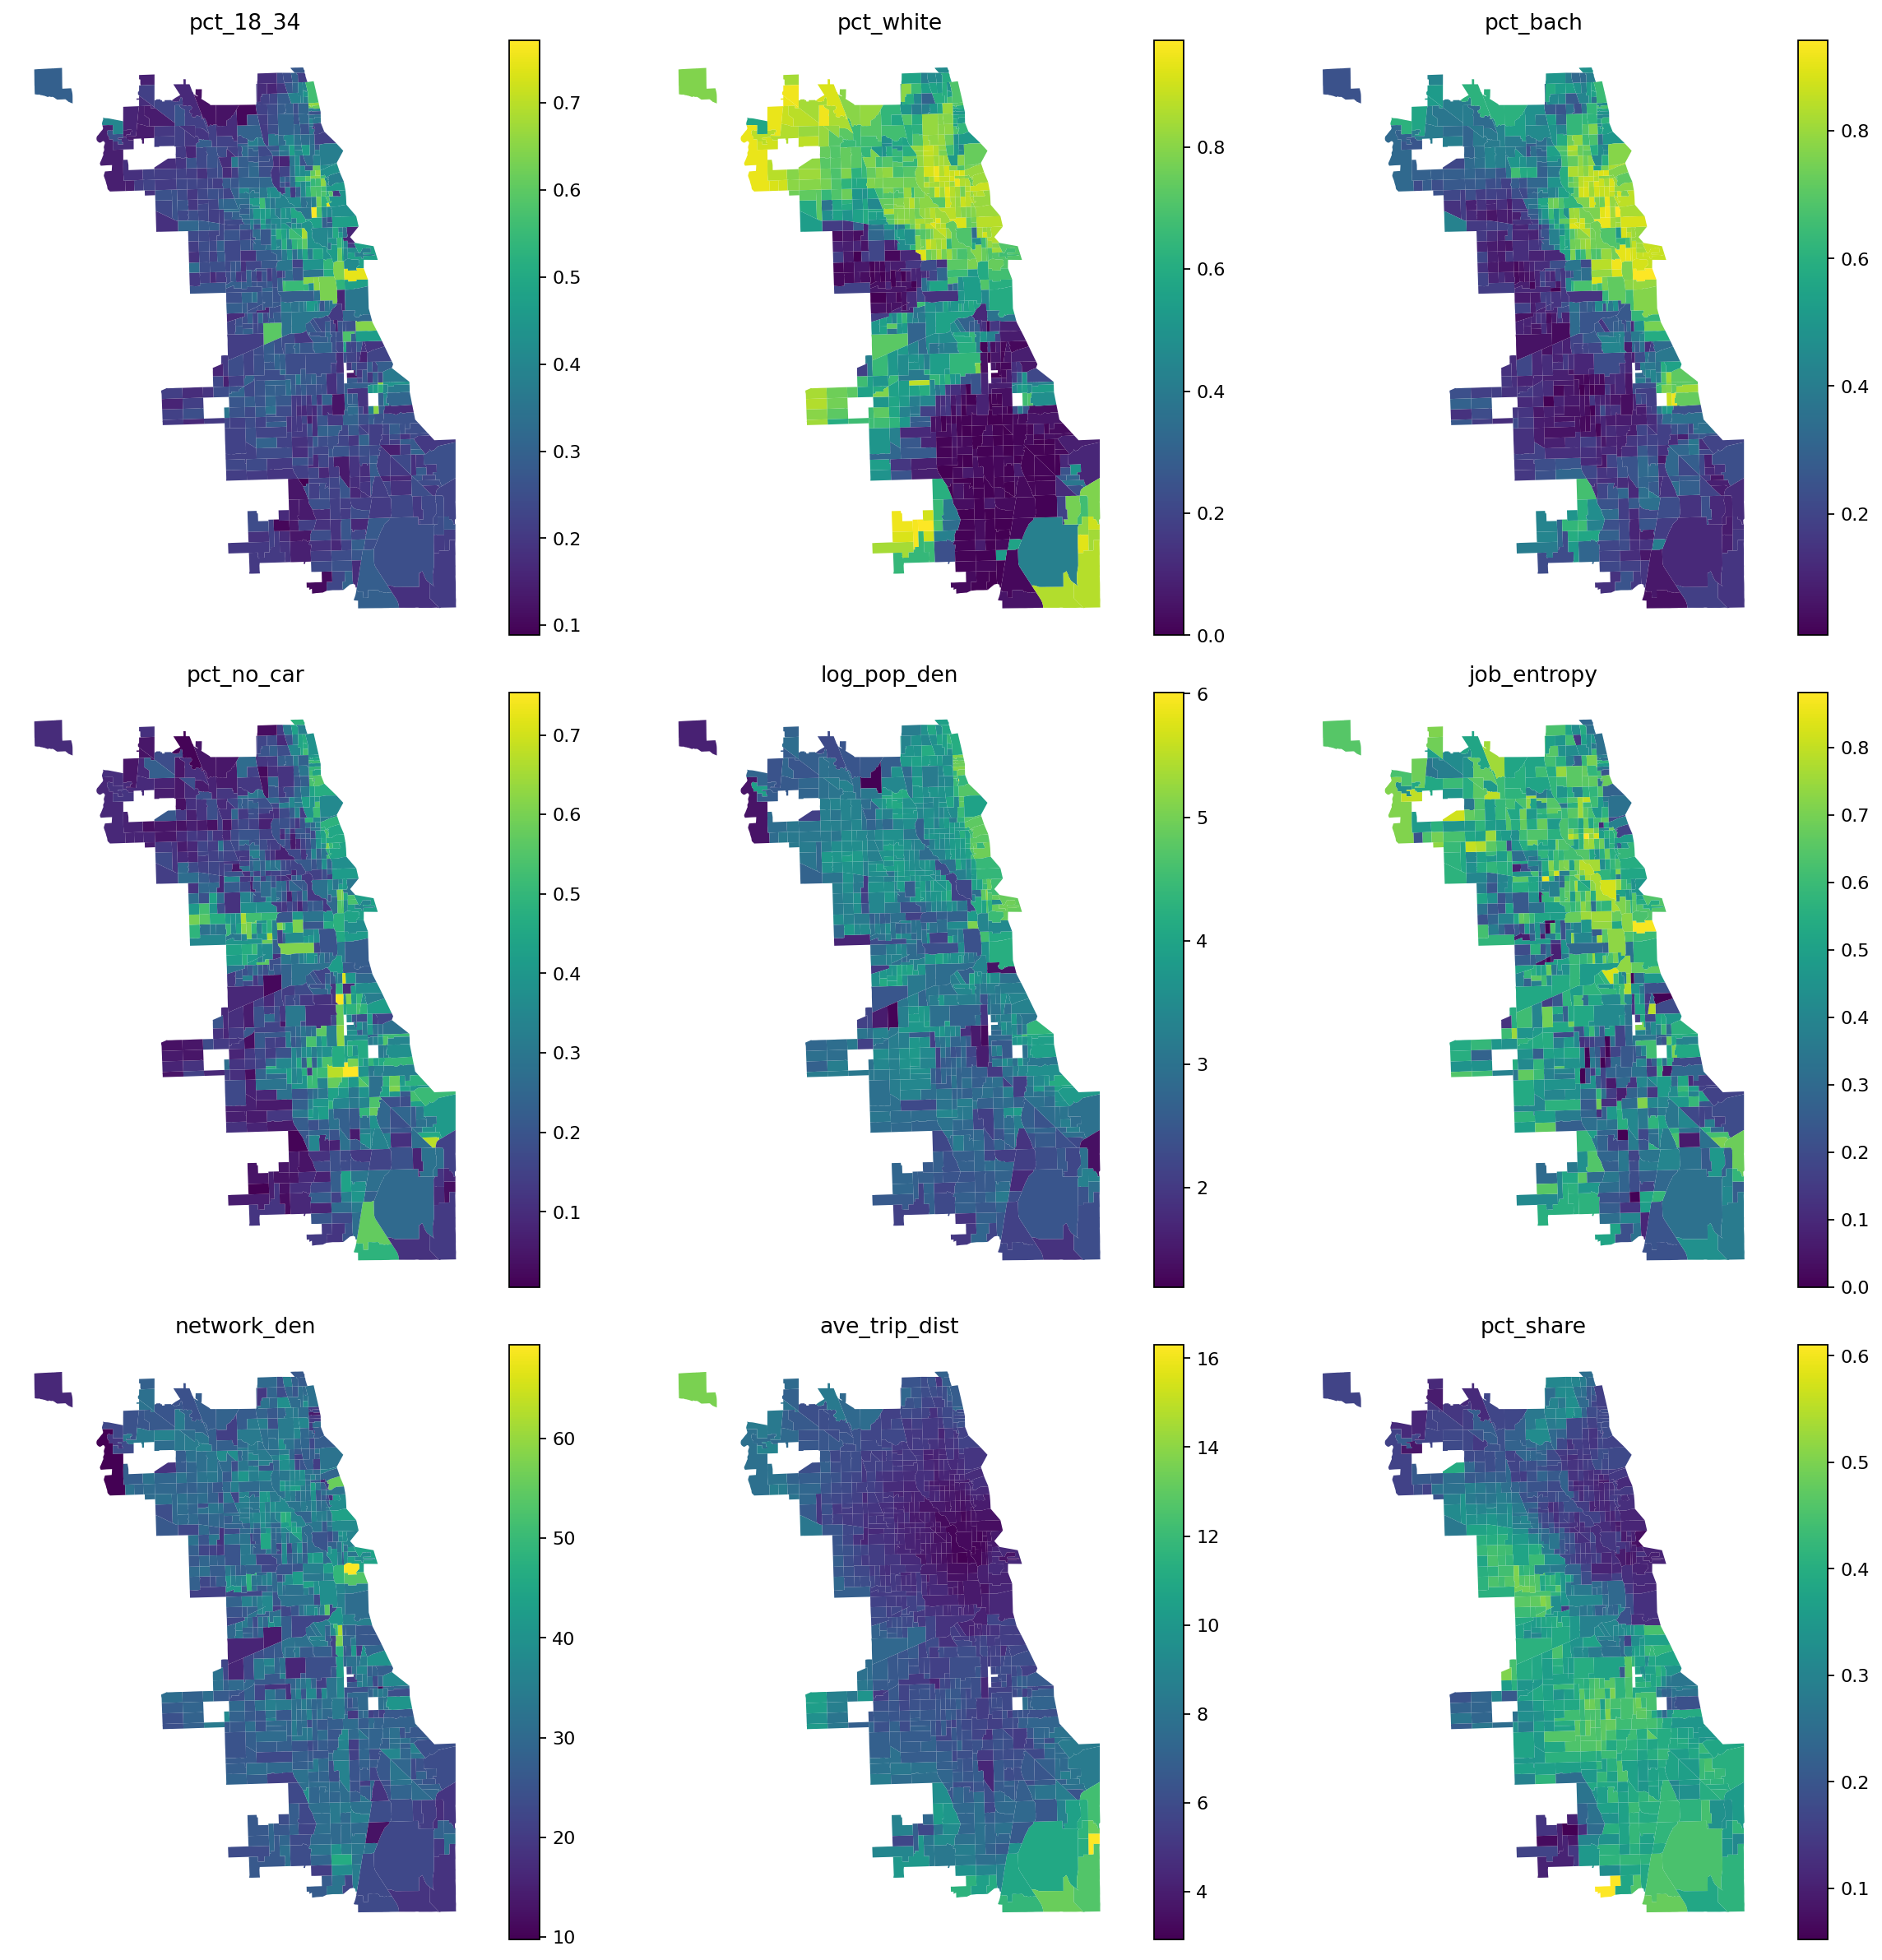

In [25]:
fig, ax = plt.subplots(3,3,figsize=(15,15),dpi=160)

for j in [2, 7, 0, 8, 3, 5, 1, 4, 6 ]:
    ax = ax.ravel()
    
    chicago.plot(ax=ax[j],column = shap_values.data[:,j],legend=True)
    
    ax[j].set_title(X_names[j],fontsize=12)
    ax[j].axis('off')
    
fig.tight_layout()